# Mortgage Workflow

The original implementation can be found at the [rapidsai notebooks-extendeds](https://github.com/rapidsai/notebooks-extended/blob/462b3b9/intermediate_notebooks/E2E/mortgage/mortgage_e2e.ipynb) site. This notebook is a re-implementation using `gQuant`.

## The Dataset
The dataset used with this workflow is derived from [Fannie Mae’s Single-Family Loan Performance Data](http://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html) with all rights reserved by Fannie Mae. This processed dataset is redistributed with permission and consent from Fannie Mae.

To acquire this dataset, please visit [RAPIDS Datasets Homepage](https://docs.rapids.ai/datasets/mortgage-data)

## Introduction
The Mortgage workflow is composed of three core phases:

1. ETL - Extract, Transform, Load
2. Data Conversion
3. ML - Training

### ETL
Data is 
1. Read in from storage
2. Transformed to emphasize key features
3. Loaded into volatile memory for conversion

### Data Conversion
Features are
1. Broken into (labels, data) pairs
2. Distributed across dask workers if using Dask.
3. Converted into compressed sparse row (CSR) matrix (DMatrix) format for XGBoost

### Machine Learning
The CSR data is fed into XGBoost or with a distributed training session with Dask-XGBoost

### Mortgage gQuant Workflow for ETL

Two modules are provided with this notebook and should be in the same location (directory) as this notebook: `mortgage_common.py` and `mortgage_gquant_plugins.py`. The plugins module contains the individuals tasks for loading the mortgage data from csv (command separated) files into `cudf` dataframes and processing/transforming these dataframes for mortgage delinquency analysis. As an example the gQuant task to calculate loan delinquecy status period features is shown below.

In [1]:
import inspect
from mortgage_gquant_plugins import CreateEverFeatures

print(inspect.getsource(CreateEverFeatures))

class CreateEverFeatures(Node):
    '''gQuant task/node to calculate delinquecy status period features.
    Refer to columns_setup method for the columns produced.
    '''
    def columns_setup(self):
        self.required = OrderedDict([
            ('loan_id', 'int64'),
            ('current_loan_delinquency_status', 'int32')
        ])

        self.retention = {
            'loan_id': 'int64',
            'ever_30': 'int8',
            'ever_90': 'int8',
            'ever_180': 'int8'
        }

    def process(self, inputs):
        '''
        '''
        gdf = inputs[0]
        everdf = gdf[['loan_id', 'current_loan_delinquency_status']]
        everdf = everdf.groupby('loan_id', method='hash', as_index=False).max()
        everdf['ever_30'] = \
            (everdf['current_loan_delinquency_status'] >= 1).astype('int8')
        everdf['ever_90'] = \
            (everdf['current_loan_delinquency_status'] >= 3).astype('int8')
        everdf['ever_180'] = \
            (everdf['cur

We create a worfklow by defining tasks and specifying their configuration (parameters) and inputs (for basics tutorial on gQuant refer to [01_tutorial.ipynb](https://github.com/rapidsai/gQuant/blob/master/notebook/01_tutorial.ipynb) and custom plugins [05_customize_nodes.ipynb](https://github.com/rapidsai/gQuant/blob/master/notebook/05_customize_nodes.ipynb)). The workflow to calculate the mortgage features and delinquecy is defined in the `mortgage_etl_workflow_def` function in `mortgage_common` module. Its code is shown below.

In [2]:
import inspect
from mortgage_common import mortgage_etl_workflow_def

print(inspect.getsource(mortgage_etl_workflow_def))

def mortgage_etl_workflow_def(
        csvfile_names=None, csvfile_acqdata=None,
        csvfile_perfdata=None):
    '''Define the ETL (extract-transform-load) portion of the mortgage
    workflow.

    :returns: gQuant workflow. Currently a simple list of dictionaries. Each
        dict specifies a task per TaskSpecSchema.
    :rtype: list
    '''
    from gquant.dataframe_flow.node import TaskSpecSchema

    _basedir = os.path.dirname(__file__)

    mortgage_lib_module = os.path.join(_basedir, 'mortgage_gquant_plugins.py')

    # print('CSVFILE_ACQDATA: ', csvfile_acqdata)
    # print('CSVFILE_PERFDATA: ', csvfile_perfdata)

    # load acquisition
    load_acqdata_task = {
        TaskSpecSchema.uid: MortgageTaskNames.load_acqdata_task_name,
        TaskSpecSchema.plugin_type: 'CsvMortgageAcquisitionDataLoader',
        TaskSpecSchema.conf: {
            'csvfile_names': csvfile_names,
            'csvfile_acqdata': csvfile_acqdata
        },
        TaskSpecSchema.inputs: [],
      

Let's visualize the mortgage ETL workflow.

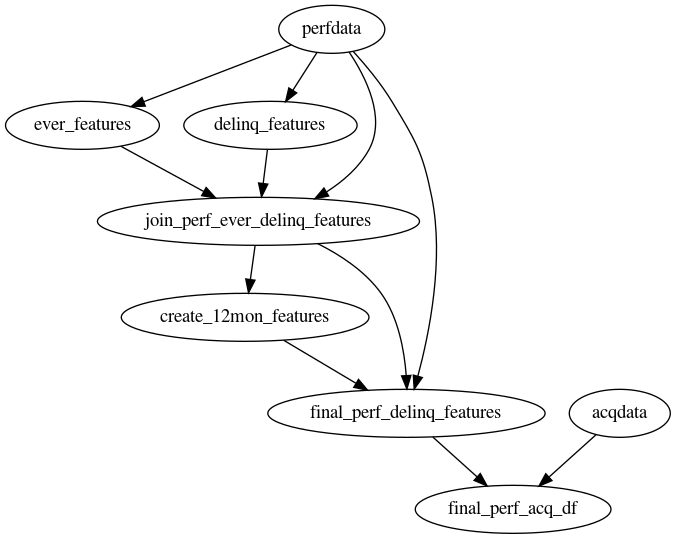

In [3]:
from gquant.dataframe_flow import viz_graph
from nxpd import draw

task_list = mortgage_etl_workflow_def()
task_graph = viz_graph(task_list)
draw(task_graph, show='ipynb')

Let's run the workflow and inspect the resultant `final_per_acq_df` dataframe. Adjust your paths below to wherever you downloaded the mortgage dataset to. The `mortgage_data` below is assumed to be in the same directory as this notebook (could be a symlink to wherever the actual data resides), otherwise adjust the paths.

In [4]:
import os
import gquant.dataframe_flow as dff
from mortgage_common import (
    mortgage_etl_workflow_def, MortgageTaskNames)

# mortgage_data_path = '/datasets/rapids_data/mortgage'
mortgage_data_path = './mortgage_data'
# _basedir = os.path.abspath('')  # path of current notebook
# mortgage_data_path = os.path.join(_basedir, 'mortgage_data')
csvfile_names = os.path.join(mortgage_data_path, 'names.csv')
acq_data_path = os.path.join(mortgage_data_path, 'acq')
perf_data_path = os.path.join(mortgage_data_path, 'perf')

# Some files out of the mortgage dataset.
csvfile_acqdata = os.path.join(acq_data_path, 'Acquisition_2000Q1.txt')
csvfile_perfdata = os.path.join(perf_data_path, 'Performance_2000Q1.txt_0')

gquant_task_list = mortgage_etl_workflow_def(
    csvfile_names, csvfile_acqdata, csvfile_perfdata)
out_list = [MortgageTaskNames.final_perf_acq_task_name]

(final_perf_acq_df,) = dff.run(gquant_task_list, out_list)

perfdata:INFO: LOADING: ./mortgage_data/perf/Performance_2000Q1.txt_0
acqdata:INFO: LOADING: ./mortgage_data/acq/Acquisition_2000Q1.txt


In [5]:
print('Mortgage Workflow Ouput CUDF Dataframe:\n', final_perf_acq_df)

Mortgage Workflow Ouput CUDF Dataframe:
     servicer  interest_rate  current_actual_upb  loan_age  remaining_months_to_legal_maturity  adj_remaining_months_to_maturity  msa ...  relocation_mortgage_indicator
0      -1.0            8.0             74319.0      12.0                               348.0                             347.0  0.0 ...                           -1.0
1      -1.0            8.0            73635.48      24.0                               336.0                             335.0  0.0 ...                           -1.0
2      -1.0            8.0            72795.41      36.0                               324.0                             322.0  0.0 ...                           -1.0
3      -1.0            8.0                -1.0       1.0                               359.0                             358.0  0.0 ...                           -1.0
4      -1.0            8.0            74264.14      13.0                               347.0                             34

We can indirectly see how much memory is being occupied on the GPU by this cudf dataframe. In my case I see `1827 MB` (assuming only this notebook is running and using the GPU).

In [6]:
!nvidia-smi --query-compute-apps=pid,process_name,used_memory --format=csv

pid, process_name, used_gpu_memory [MiB]
9617, /home/avolkov/progs/python_installs/miniconda3/envs/py36-rapids/bin/python, 1827 MiB


We can clear this GPU memory by deleting the cudf dataframe and running python garbage collector to force garbage collection. After clearing I see `171 MB` occupied on the GPU.

In [7]:
import gc  # python garbage collector

del(final_perf_acq_df)
gc.collect()

!nvidia-smi --query-compute-apps=pid,process_name,used_memory --format=csv

pid, process_name, used_gpu_memory [MiB]
9617, /home/avolkov/progs/python_installs/miniconda3/envs/py36-rapids/bin/python, 171 MiB


### Mortgage Workflow Runner

The example above loads just one performance and acqusition datafile. The mortgage dataset is broken down into many csv files. The complete worfklow reads these csv files into cudf dataframes, does all the processing on the GPU, then converts to PyArrow table (essentially arrow dataframes), concatenates the arrow tables, and as a final stage converts into one massive pandas dataframe. From this concatenated dataframe the delinquency column is used as labels and the remaining columns are used as training features. The xgboost DMatrix is instantiated from the features and labels and passed to the xgboost booster trainer. The xgboost trainer copies the data to GPU again and trains on GPU.

Below we define the complete data training workflow. This is the non-distributed implementation. The dask distributed implementation will follow. The parameters for the mortgage runner are displayed (limited to 2 files). Below I load 12 files for the actual run. Adjust the `part_count` to something manageable on your system. The limitation will be the host RAM for how many dataframes can be concatenated and the DMatrix instantiated.

Parameters configuration for Mortgage Workflow Runner (shortened to 2 files)
[
  {
    "replace_spec": {
      "acqdata": {
        "conf": {
          "csvfile_names": "./mortgage_data/names.csv",
          "csvfile_acqdata": "./mortgage_data/acq/Acquisition_2000Q1.txt"
        }
      },
      "perfdata": {
        "conf": {
          "csvfile_perfdata": "./mortgage_data/perf/Performance_2000Q1.txt_0"
        }
      }
    },
    "task_list": "This is gquant_task_list",
    "out_list": [
      "final_perf_acq_df"
    ]
  },
  {
    "replace_spec": {
      "acqdata": {
        "conf": {
          "csvfile_names": "./mortgage_data/names.csv",
          "csvfile_acqdata": "./mortgage_data/acq/Acquisition_2000Q2.txt"
        }
      },
      "perfdata": {
        "conf": {
          "csvfile_perfdata": "./mortgage_data/perf/Performance_2000Q2.txt_0"
        }
      }
    },
    "task_list": "This is gquant_task_list",
    "out_list": [
      "final_perf_acq_df"
    ]
  }
]


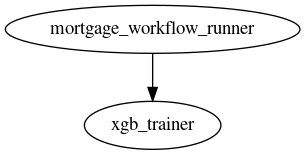

In [8]:
import os
import json

from gquant.dataframe_flow import viz_graph
from nxpd import draw

from gquant.dataframe_flow.node import TaskSpecSchema
import gquant.dataframe_flow as dff

from mortgage_common import (
    mortgage_etl_workflow_def, generate_mortgage_gquant_run_params_list,
    MortgageTaskNames)

start_year = 2000
end_year = 2001  # end_year is inclusive
# end_year = 2016  # end_year is inclusive
# part_count = 16  # the number of data files to train against
# part_count = 12  # the number of data files to train against
part_count = 2  # the number of data files to train against

# ADJUST YOUR MORTGAGE DATAPATH IF DIFFERENT
mortgage_data_path = './mortgage_data'

gquant_task_list = mortgage_etl_workflow_def()
mortgage_run_params_dict_list = generate_mortgage_gquant_run_params_list(
    mortgage_data_path, start_year, end_year, part_count, gquant_task_list)

mortgage_run_params_dict_list_for_printing = mortgage_run_params_dict_list.copy()
for iparams_dict in mortgage_run_params_dict_list_for_printing:
    iparams_dict['task_list'] = 'This is gquant_task_list'

print('Parameters configuration for Mortgage Workflow Runner '
      '(shortened to 2 files)')
print(json.dumps(mortgage_run_params_dict_list_for_printing, indent=2))

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #
# ADJUST PART_COUNT FOR YOUR SYSTEM MEMORY
part_count = 12  # the number of data files to train against
# part_count = 4  # the number of data files to train against

mortgage_run_params_dict_list = generate_mortgage_gquant_run_params_list(
    mortgage_data_path, start_year, end_year, part_count, gquant_task_list)

_basedir = os.path.abspath('')  # path of current notebook
mortgage_lib_module = os.path.join(_basedir, 'mortgage_gquant_plugins.py')

mortgage_workflow_runner_task = {
    TaskSpecSchema.uid:
        MortgageTaskNames.mortgage_workflow_runner_task_name,
    TaskSpecSchema.plugin_type: 'MortgageWorkflowRunner',
    TaskSpecSchema.conf: {
        'mortgage_run_params_dict_list': mortgage_run_params_dict_list
    },
    TaskSpecSchema.inputs: [],
    TaskSpecSchema.modulepath: mortgage_lib_module
}

# Can be multi-gpu. Set ngpus > 1. This is different than dask xgboost
# which is distributed multi-gpu i.e. dask-xgboost could distribute on one
# node or multiple nodes. In distributed mode the dmatrix is distributed.
ngpus = 1
xgb_gpu_params = {
    'nround':            100,
    'max_depth':         8,
    'max_leaves':        2 ** 8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'min_child_weight':  30,
    'tree_method':       'gpu_hist',
    'n_gpus':            ngpus,
    # 'distributed_dask':  True,
    'loss':              'ls',
    # 'objective':         'gpu:reg:linear',
    'objective':         'reg:squarederror',
    'max_features':      'auto',
    'criterion':         'friedman_mse',
    'grow_policy':       'lossguide',
    'verbose':           True
}

xgb_trainer_task = {
    TaskSpecSchema.uid: MortgageTaskNames.xgb_trainer_task_name,
    TaskSpecSchema.plugin_type: 'XgbMortgageTrainer',
    TaskSpecSchema.conf: {
        'delete_dataframes': False,
        'xgb_gpu_params': xgb_gpu_params
    },
    TaskSpecSchema.inputs: [
        MortgageTaskNames.mortgage_workflow_runner_task_name
    ],
    TaskSpecSchema.modulepath: mortgage_lib_module
}

task_list = [mortgage_workflow_runner_task, xgb_trainer_task]
task_graph = viz_graph(task_list)
draw(task_graph, show='ipynb')

Refer to `MortgageWorkflowRunner` and `XgbMortgageTrainer` in the `mortgage_gquant_plugins.py` module for the details of the mortage workflow runner and xgboost trainer tasks.

Note the novel manner in which gQuant is used. The `mortgage_workflow_runner` actually runs another gQuant workflow defined by `mortgage_etl_workflow_def()` for each set of acquisition and performance csv files. The output from `mortgage_workflow_runner` is a pandas dataframe (concatenated from processing multiple `final_per_acq_df` dataframes). The `xgb_trainer` is used in an atypical manner. It does not output a dataframe, instead it produces an XGBoost booster. Even though we mostly focus on dataframe flow with gQuant, if the tasks input/output something beside dataframes then gQuant will still run the workflow. When a task does not output a dataframe then gQuant does not perform columns validation. Currently, the responsibility is on the end-user to validate or make sure the input/output types match for the wired non-dataframe tasks. Above only the `xgb_trainer` task's output is not a datframe.

We can run the workflow now and obtain the XGBoost trained booster. You can monitor the GPU utilization in a terminal using `nvidia-smi`. On my node I have 125GB of host RAM and two 16GB GPU cards. I am able to process 12 dataframes. If I load more than 12 dataframes, then the workflow crashes during DMatrix creation due to out of memory error. The DMatrix instantiation seems to inflate the data temporarily and I run out of memory on the host. In a terminal you can watch with nvidia-smi the utilization on the GPU. During XGBoost training I typically observe:

```
$ nvidia-smi --query-compute-apps=pid,process_name,used_memory --format=csv
pid, process_name, used_gpu_memory [MiB]
27774, /home/avolkov/progs/python_installs/miniconda3/envs/py36-rapids/bin/python, 11025 MiB

$ watch -n 0.5 nvidia-smi pmon -c 1
# gpu        pid  type    sm   mem   enc   dec   command
# Idx          #   C/G     %     %     %     %   name
    0      27774     C    99    28     0     0   python
    1          -     -     -     -     -     -   -

```

The DMatrix occupies 11GB of GPU memory and XGBoost training is utilizing 99% of compute processing power on the GPU (specifying `ngpus=2` will split the training across two GPUs).

In [9]:
# out_list = [MortgageTaskNames.xgb_trainer_task_name]
# (bst,) = dff.run(task_list, out_list)

out_list = [
    MortgageTaskNames.mortgage_workflow_runner_task_name,
    MortgageTaskNames.xgb_trainer_task_name
]
((mortgage_feat_df_pandas, delinq_df_pandas), bst,) = \
    dff.run(task_list, out_list)
# print(mortgage_feat_df_pandas.head())
# print(delinq_df_pandas.head())

print('XGBOOST BOOSTER:\n', bst)

mortgage_workflow_runner:INFO: TRYING TO LOAD 12 FRAMES
perfdata:INFO: LOADING: ./mortgage_data/perf/Performance_2000Q1.txt_0
acqdata:INFO: LOADING: ./mortgage_data/acq/Acquisition_2000Q1.txt
mortgage_workflow_runner:INFO: LOADED 1 FRAMES
perfdata:INFO: LOADING: ./mortgage_data/perf/Performance_2000Q2.txt_0
acqdata:INFO: LOADING: ./mortgage_data/acq/Acquisition_2000Q2.txt
mortgage_workflow_runner:INFO: LOADED 2 FRAMES
perfdata:INFO: LOADING: ./mortgage_data/perf/Performance_2000Q3.txt_0
acqdata:INFO: LOADING: ./mortgage_data/acq/Acquisition_2000Q3.txt
mortgage_workflow_runner:INFO: LOADED 3 FRAMES
perfdata:INFO: LOADING: ./mortgage_data/perf/Performance_2000Q4.txt_1
acqdata:INFO: LOADING: ./mortgage_data/acq/Acquisition_2000Q4.txt
mortgage_workflow_runner:INFO: LOADED 4 FRAMES
perfdata:INFO: LOADING: ./mortgage_data/perf/Performance_2000Q4.txt_0
acqdata:INFO: LOADING: ./mortgage_data/acq/Acquisition_2000Q4.txt
mortgage_workflow_runner:INFO: LOADED 5 FRAMES
perfdata:INFO: LOADING: ./mor

/home/avolkov/progs/python_installs/miniconda3/envs/py36-rapids/lib/python3.6/site-packages/xgboost-0.83.dev0-py3.6.egg/xgboost/core.py:604: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


xgb_trainer:INFO: JUST AFTER DMATRIX
xgb_trainer:INFO: HOST RAM (MB) TOTAL 128904; USED 63598; FREE 46631
xgb_trainer:INFO: CLEAR MEMORY JUST BEFORE XGBOOST TRAINING
xgb_trainer:INFO: HOST RAM (MB) TOTAL 128904; USED 48521; FREE 61708
xgb_trainer:INFO: RUNNING XGBOOST TRAINING
XGBOOST BOOSTER:


Specifying ngpus=2 will split the training across two GPUs, but in a non-distributed manner (this approach is being [deprecated](https://xgboost.readthedocs.io/en/latest/gpu/#single-node-multi-gpu) in favor of distributed). If you would like to run with 2 GPUs in this manner, convert the cell below to code (from raw format to code select cell and press Esc+y), and run below on 2 GPUs. If you don't have at least two GPUs do not run the cell below.

During XGBoost training on 2 GPUs above, I typically observe (pid differs from run to run):
```
$ nvidia-smi --query-compute-apps=pid,process_name,used_memory --format=csv
pid, process_name, used_gpu_memory [MiB]
12819, /home/avolkov/progs/python_installs/miniconda3/envs/py36-rapids/bin/python, 5965 MiB
12819, /home/avolkov/progs/python_installs/miniconda3/envs/py36-rapids/bin/python, 5905 MiB


$ watch -n 0.5 nvidia-smi pmon -c 1
# gpu        pid  type    sm   mem   enc   dec   command
# Idx          #   C/G     %     %     %     %   name
    0      12819     C    98    13     0     0   python
    1      12819     C    99    13     0     0   python
```

In [10]:
# DISPLAY CURRENT MEMORY ON HOST AND GPU
!free -m
!echo
!nvidia-smi --query-compute-apps=pid,process_name,used_memory --format=csv

              total        used        free      shared  buff/cache   available
Mem:         128904       49325       60901        6250       18676       69887
Swap:             0           0           0

pid, process_name, used_gpu_memory [MiB]
9617, /home/avolkov/progs/python_installs/miniconda3/envs/py36-rapids/bin/python, 11023 MiB


### DASK Distributed Mortgage Workflow Runner

Typically dask with cudf (dask-cudf) or dask with pandas dataframes is used to distribute the dataframe itself. Then operations are performed on the distributed dataframe. The implementation below differs. We will startup GPU dask workers (in my case I have 2 GPUs on the machine) and each worker will run the mortgage workflow to generate a DMatrix. Thus in the end what we will have can be thought of as a distributed DMatrix. It is just two DMatrices one on each worker. This distributed dmatrix is then passed to the dask-xgboost trainer.

#### RECOMMEND TO RESTART THE JUPYTER KERNEL

To release GPU resources from previous non-distributed runs above I recommend you RESTART the Jupyter kernel and continue with the cells below. Otherwise you might run out of memory and/or you might see additional processes consuming GPU.

We start by clearing previous non-distributed run (in case the cells before this one were executed and Jupyter kernel was not restarted), and starting a dask cluster and client.

In [11]:
# Disable NCCL P2P. Only necessary for versions of NCCL < 2.4
# https://rapidsai.github.io/projects/cudf/en/0.8.0/dask-xgb-10min.html#Disable-NCCL-P2P.-Only-necessary-for-versions-of-NCCL-%3C-2.4
%env NCCL_P2P_DISABLE=1

# CLEAN MEMORY FROM RUN BEFORE
import gc

from contextlib import suppress

with suppress(Exception):
    del(mortgage_feat_df_pandas)

with suppress(Exception):
    del(delinq_df_pandas)

with suppress(Exception):
    del(bst)

gc.collect()

from dask_cuda import LocalCUDACluster
from dask.distributed import Client

print('\nHOST RAM')
!free -m

print('\nGPU STATUS')
# !nvidia-smi --query-compute-apps=pid,process_name,used_memory --format=csv
nvsmiquery = !nvidia-smi --query-compute-apps=pid,process_name,used_memory --format=csv
# Output will be empty if nothing is happening on GPUs.
if len(nvsmiquery) == 1:
    print('\n'.join(nvsmiquery+['No running processes found']))
else:
    print('\n'.join(nvsmiquery))

print('\n\n')
# Start cluster and dask client.

memory_limit = 128e9
threads_per_worker = 4
cluster = LocalCUDACluster(
    memory_limit=memory_limit,
    threads_per_worker=threads_per_worker)
client = Client(cluster)

print('DASK LOCAL CUDA CLUSTER')
client

env: NCCL_P2P_DISABLE=1

HOST RAM
              total        used        free      shared  buff/cache   available
Mem:         128904        2059      108169        6248       18675      117155
Swap:             0           0           0

GPU STATUS
pid, process_name, used_gpu_memory [MiB]
9617, /home/avolkov/progs/python_installs/miniconda3/envs/py36-rapids/bin/python, 189 MiB



DASK LOCAL CUDA CLUSTER


Client Scheduler: tcp://127.0.0.1:35199 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 8 Memory: 256.00 GB


Now we define the gQuant workflow similar to how we did it before in the non-distributed case except we will use tasks `DaskMortgageWorkflowRunner` and `DaskXgbMortgageTrainer` in the `mortgage_gquant_plugins.py` module. Refer to these tasks in the `mortgage_gquant_plugins.py` for code details.

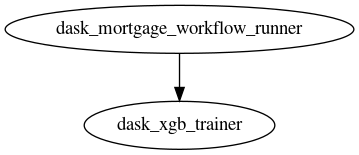

In [12]:
import os
from gquant.dataframe_flow import viz_graph
from nxpd import draw

from gquant.dataframe_flow.node import TaskSpecSchema
import gquant.dataframe_flow as dff

from mortgage_common import (
    mortgage_etl_workflow_def, generate_mortgage_gquant_run_params_list,
    MortgageTaskNames)


# mortgage_data_path = '/datasets/rapids_data/mortgage'
mortgage_data_path = './mortgage_data'

# Using some default csv files for testing.
gquant_task_list = mortgage_etl_workflow_def()

start_year = 2000
end_year = 2001  # end_year is inclusive
# end_year = 2016  # end_year is inclusive

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #
# ADJUST PART_COUNT FOR YOUR SYSTEM MEMORY
# able to do 18 with create_dmatrix_serially set to True
# Otherwise need more host RAM. DGX-1 for Analytics has 1TB RAM.
# part_count = 16  # the number of data files to train against
# create_dmatrix_serially = False
part_count = 18  # the number of data files to train against
create_dmatrix_serially = True

# Use RAPIDS Memory Manager. Seems to work fine without it.
use_rmm = False

# Clean up intermediate dataframes in the xgboost training task.
delete_dataframes = True

mortgage_run_params_dict_list = generate_mortgage_gquant_run_params_list(
    mortgage_data_path, start_year, end_year, part_count, gquant_task_list)

_basedir = os.path.abspath('')  # path of current notebook
mortgage_lib_module = os.path.join(_basedir, 'mortgage_gquant_plugins.py')

# filter_dask_logger is primarily for displaying the log in the jupyter
# notebook. The dask distributed logger is used by gQuant mortgage tasks
# when running on dask workers.
filter_dask_logger = True

mortgage_workflow_runner_task = {
    TaskSpecSchema.uid:
        MortgageTaskNames.dask_mortgage_workflow_runner_task_name,
    TaskSpecSchema.plugin_type: 'DaskMortgageWorkflowRunner',
    TaskSpecSchema.conf: {
        'mortgage_run_params_dict_list': mortgage_run_params_dict_list,
        'client': client,
        'use_rmm': use_rmm,
        'filter_dask_logger': filter_dask_logger
    },
    TaskSpecSchema.inputs: [],
    TaskSpecSchema.modulepath: mortgage_lib_module
}

# task_list = [mortgage_workflow_runner_task]
#
# out_list = [MortgageTaskNames.dask_mortgage_workflow_runner_task_name]
# ((mortgage_feat_df_delinq_df_pandas_futures),) = \
#     dff.run(task_list, out_list)
#
# print('MORTGAGE_FEAT_DF_DELINQ_DF_PANDAS_FUTURES: ',
#       mortgage_feat_df_delinq_df_pandas_futures)

dxgb_gpu_params = {
    'nround':            100,
    'max_depth':         8,
    'max_leaves':        2 ** 8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'min_child_weight':  30,
    'tree_method':       'gpu_hist',
    'n_gpus':            1,
    'distributed_dask':  True,
    'loss':              'ls',
    # 'objective':         'gpu:reg:linear',
    'objective':         'reg:squarederror',
    'max_features':      'auto',
    'criterion':         'friedman_mse',
    'grow_policy':       'lossguide',
    'verbose':           True
}

dxgb_trainer_task = {
    TaskSpecSchema.uid: MortgageTaskNames.dask_xgb_trainer_task_name,
    TaskSpecSchema.plugin_type: 'DaskXgbMortgageTrainer',
    TaskSpecSchema.conf: {
        'create_dmatrix_serially': create_dmatrix_serially,
        # Able to load 18 files with create_dmatrix_serially set
        # to True. 16 is the max I could do otherwise.
        'delete_dataframes': delete_dataframes,
        'dxgb_gpu_params': dxgb_gpu_params,
        'client': client,
        'filter_dask_logger': filter_dask_logger
    },
    TaskSpecSchema.inputs: [
        MortgageTaskNames.dask_mortgage_workflow_runner_task_name
    ],
    TaskSpecSchema.modulepath: mortgage_lib_module
}

task_list = [mortgage_workflow_runner_task, dxgb_trainer_task]

task_graph = viz_graph(task_list)
draw(task_graph, show='ipynb')

Final step we run the workflow.

In [13]:
# Look in the terminal where the jupyter was launched from
# for real-time logging. Otherwise, the logging for individual
# tasks is captured and displayed after the workers
# complete that task.
out_list = [MortgageTaskNames.dask_xgb_trainer_task_name]
(bst,) = dff.run(task_list, out_list)

print('XGBOOST BOOSTER:\n', bst)

dask_mortgage_workflow_runner:INFO: TRYING TO LOAD 18 FRAMES
dask_mortgage_workflow_runner:INFO: SPLIT MORTGAGE DATA INTO 2 CHUNKS AMONGST 2 WORKERS
dask_mortgage_workflow_runner:INFO: 10:32:29.327 distributed.worker.mortgage_workflow_runner:INFO: WORKER gpu-0 RUNNING MORTGAGE gQUANT DataframeFlow
dask_mortgage_workflow_runner:INFO: 10:32:29.327 distributed.worker.mortgage_workflow_runner:INFO: WORKER gpu-0 NCCL_P2P_DISABLE: 1
dask_mortgage_workflow_runner:INFO: 10:32:29.327 distributed.worker.mortgage_workflow_runner:INFO: WORKER gpu-0 CUDA_VISIBLE_DEVICES: 0,1
dask_mortgage_workflow_runner:INFO: 10:32:33.421 distributed.worker.csv_mortgage_performance_data_loader:INFO: WORKER gpu-0 LOADING: ./mortgage_data/perf/Performance_2000Q1.txt_0
dask_mortgage_workflow_runner:INFO: 10:32:43.085 distributed.worker.csv_mortgage_acquisition_data_loader:INFO: WORKER gpu-0 LOADING: ./mortgage_data/acq/Acquisition_2000Q1.txt
dask_mortgage_workflow_runner:INFO: 10:32:45.559 distributed.worker.mortgage

During Dask-XGBoost training on 2 GPUs above I observed:

```
$ nvidia-smi --query-compute-apps=pid,process_name,used_memory --format=csv
pid, process_name, used_gpu_memory [MiB]
15945, /home/avolkov/progs/python_installs/miniconda3/envs/py36-rapids/bin/python, 9135 MiB
15946, /home/avolkov/progs/python_installs/miniconda3/envs/py36-rapids/bin/python, 8681 MiB

$ watch -n 0.5 nvidia-smi pmon -c 1
# gpu        pid  type    sm   mem   enc   dec   command
# Idx          #   C/G     %     %     %     %   name
    0      15945     C    99    13     0     0   python
    1      15946     C    99    12     0     0   python
```

### Summary

We re-implemented the RAPIDS mortgage ETL notebook using gQuant. The benefit of the gQuant implementation is that one can readily break down their workflow into modular parts. It becomes much easier to understand and optimize the individual components of the workflow pipeline.

A non-distributed and a distributed version was demonstrated. The benefits of distributed dask version were that more data was processed (18 files vs 12 files which amounts to 6GB of more data) and the dask-distributed version ran ETL in parallel on two workers (one worker per GPU) thus speeding up ETL. Using distributed version we could scale to multiple nodes as well.

Two scripts are provided along with this notebook `mortgage_run_workflow_local.py` and `mortgage_run_workflow_daskdistrib.py` which run similar code to what was presented in this notebook.

In [14]:
# CLEAN UP
client.close()
cluster.close()